# OpenVINO™ Explainable AI Toolkit: Classification Explanation

**OpenVINO™ Explainable AI (XAI) Toolkit** provides a suite of XAI algorithms for visual explanation of
[OpenVINO™](https://github.com/openvinotoolkit/openvino) Intermediate Representation (IR) models.

This notebook shows an example how to use OpenVINO XAI.

It depicts a heatmap with areas of interest where neural network (classification or detection) focuses before making a decision. 

Model explanation helps to identify the parts of the input that are responsible for the model's prediction, which is useful for analyzing model's performance.

#### Table of contents:

- [Prerequisites](#Prerequisites)
    - [Install requirements](#Install-requirements)
    - [Imports](#Imports)
    - [Download IR model](#Download-IR-model)
    - [Load the Image](#Load-the-Image)
    - [Preprocess image for MobileNet](#Preprocess-image-for-MobileNet)
- [Basic usage: Auto mode explainer](#Basic-usage:-Auto-mode-explainer)
    - [Create Explainer](#Create-Explainer)
    - [Do explanation](#Do-explanation)
    - [Visualize saliency maps](#Visualize-saliency-maps)
    - [Save saliency maps](#Save-saliency-maps)
    - [Return saliency maps for all classes](#Return-saliency-maps-for-all-classes)
- [Pre- and post-process functions](#Pre--and-post-process-functions)
- [Visualization Parameters](#Visualization-Parameters)
- [White Box explainer](#White-Box-explainer)
    - [Recipro-CAM explain method](#Recipro-CAM-explain-method)
    - [Insert XAI branch](#Insert-XAI-branch)
    - [Insertion-related parameters](#Insertion-related-parameters)
- [Black Box explainer](#Black-Box-explainer)
- [Advanced](#Advanced)
    - [Import ImageNet label names and add them to saliency maps](#Import-ImageNet-label-names-and-add-them-to-saliency-maps)
    - [Activation map explain method](#Activation-map-explain-method)



## Prerequisites
[back to top ⬆️](#Table-of-contents:)



### Install requirements
[back to top ⬆️](#Table-of-contents:)


In [1]:
import platform

# Install openvino package
%pip install -q "openvino>=2023.1.0" opencv-python tqdm

# Install openvino xai package
# Make sure to use python3.10 and higher
%pip install git+https://github.com/openvinotoolkit/openvino_xai.git@releases/1.0.0

if platform.system() != "Windows":
    %pip install -q "matplotlib>=3.4"
else:
    %pip install -q "matplotlib>=3.4,<3.7"

Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/openvinotoolkit/openvino_xai.git (to revision releases/1.0.0) to /tmp/pip-req-build-dz7unemq
  Running command git clone --filter=blob:none --quiet https://github.com/openvinotoolkit/openvino_xai.git /tmp/pip-req-build-dz7unemq
  Running command git checkout -b releases/1.0.0 --track origin/releases/1.0.0
  Switched to a new branch 'releases/1.0.0'
  Branch 'releases/1.0.0' set up to track remote branch 'releases/1.0.0' from 'origin'.
  Resolved https://github.com/openvinotoolkit/openvino_xai.git to commit e2cd66f22ae6a3c3e770015f63aec936103aa94b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Imports
[back to top ⬆️](#Table-of-contents:)

In [2]:
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import openvino.runtime as ov
from openvino.runtime.utils.data_helpers.wrappers import OVDict

import openvino_xai as xai
from openvino_xai.explainer import ExplainMode

from openvino_xai.explainer.explanation import Explanation

# Fetch `notebook_utils` module
import requests

r = requests.get(
    url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py",
)

open("notebook_utils.py", "w").write(r.text)

from notebook_utils import download_file

### Download IR model
[back to top ⬆️](#Table-of-contents:)


In this notebook for demonstration purposes we'll use an already converted to IR model from OpenVINO storage. 
 <!-- That model originally from timm storage and requires timm preprocessing (proper scaling and normalization). -->

<!-- You are able to run explainer on any IR model as far as passed `preprocess_fn` reflect preprocessing required for the actual model. -->

In [3]:
base_artifacts_dir = Path("./artifacts").expanduser()

model_name = "v3-small_224_1.0_float"
model_xml_name = f"{model_name}.xml"
model_bin_name = f"{model_name}.bin"

model_xml_path = base_artifacts_dir / model_xml_name

base_url = "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/models/mobelinet-v3-tf/FP32/"

if not model_xml_path.exists():
    download_file(base_url + model_xml_name, model_xml_name, base_artifacts_dir)
    download_file(base_url + model_bin_name, model_bin_name, base_artifacts_dir)
else:
    print(f"{model_name} already downloaded to {base_artifacts_dir}")

v3-small_224_1.0_float already downloaded to artifacts


In [4]:
model_path = model_xml_path

### Load the Image
[back to top ⬆️](#Table-of-contents:)

'data/coco.jpg' already exists.


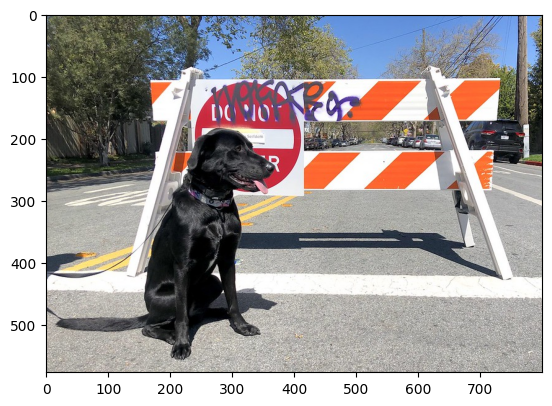

In [5]:
# Download the image from the openvino_notebooks storage
image_filename = download_file(
    "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/image/coco.jpg",
    directory="data",
)

# The MobileNet model expects images in RGB format.
image = cv2.cvtColor(cv2.imread(filename=str(image_filename)), code=cv2.COLOR_BGR2RGB)
plt.imshow(image);

### Preprocess image for MobileNet
[back to top ⬆️](#Table-of-contents:)

In [6]:
# Resize to MobileNet input image shape.
preprocessed_image = cv2.resize(src=image, dsize=(224, 224))
# Add batch dimention
preprocessed_image = np.expand_dims(preprocessed_image, 0)

## Basic usage: Auto mode explainer
[back to top ⬆️](#Table-of-contents:)

Under the hood of the auto mode: will try to run white-box mode, if fails => will run black-box mode. See more details about white_box and black-box modes below.

Generating saliency maps involves model inference. Explainer will perform model inference but for that it requires `preprocess_fn` and `postprocess_fn`.  
On this stage we can avoid passing `preprocess_fn` by passing data that have been already preprocessed above (resizing and adding batch dimention). To learn more about pre- and post-process functions, refer to the [Pre- and post-process functions](#Pre--and-post-process-functions). 

### Create Explainer
[back to top ⬆️](#Table-of-contents:)

In [7]:
# Create ov.Model
model = ov.Core().read_model(model_path)

# Create explainer object
explainer = xai.Explainer(
    model=model,
    task=xai.Task.CLASSIFICATION,
)

INFO:openvino_xai:Assigning preprocess_fn to identity function assumes that input images were already preprocessed by user before passing it to the model. Please define preprocessing function OR preprocess images beforehand.
INFO:openvino_xai:Target insertion layer is not provided - trying to find it in auto mode.
INFO:openvino_xai:Using ReciproCAM method (for CNNs).
INFO:openvino_xai:Explaining the model in white-box mode.


### Do explanation
[back to top ⬆️](#Table-of-contents:)

In [8]:
# Generate explanation, by default you can choose classes to generate maps for. Here it's 206 - flat-coated retriever
retriever_class_index = 206
explanation = explainer(preprocessed_image, targets=[retriever_class_index])

### Visualize saliency maps
[back to top ⬆️](#Table-of-contents:)

Saliency maps were generated for the following classes: [206]
Saliency map size: (224, 224, 3)


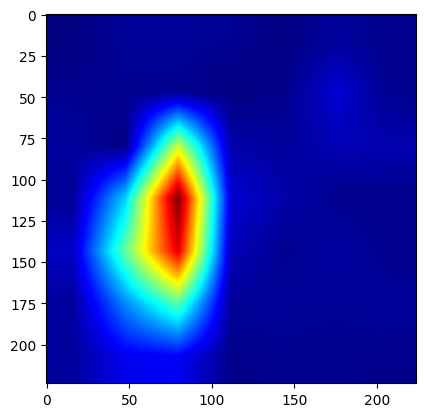

In [9]:
explanation: Explanation
explanation.saliency_map  # Dict[int: np.ndarray] where key - class id, value - processed saliency map e.g. 354x500x3

# Check saved saliency maps
print(f"Saliency maps were generated for the following classes: {list(explanation.saliency_map.keys())}")
print(f"Saliency map size: {explanation.shape}")

# Show saliency maps for retriever class
retriever_raw_sal_map = explanation.saliency_map[retriever_class_index]
plt.imshow(retriever_raw_sal_map);

### Save saliency maps
[back to top ⬆️](#Table-of-contents:)

In [10]:
# Save saliency map
output = base_artifacts_dir / "explain_auto"
explanation.save(output)

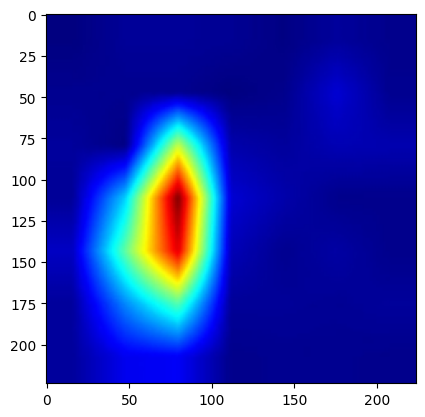

In [11]:
# See saved saliency maps
image_sal_map = cv2.imread(f"{output}/target_{retriever_class_index}.jpg")
image_sal_map = cv2.cvtColor(image_sal_map, cv2.COLOR_BGR2RGB)
plt.imshow(image_sal_map);

### Return saliency maps for all classes
[back to top ⬆️](#Table-of-contents:)

In [12]:
explanation = explainer(preprocessed_image, targets=-1)

# Check saved saliency maps
print(f"Saliency maps were generated for the following classes: {list(explanation.saliency_map.keys())}")
print(f"Saliency map size: {explanation.shape}")

error: OpenCV(4.10.0) /io/opencv/modules/imgproc/src/resize.cpp:3789: error: (-215:Assertion failed) !dsize.empty() in function 'resize'


## Pre- and post-process functions
[back to top ⬆️](#Table-of-contents:)


To avoid preprocesssing data before passing it to explainer, you can specify `preprocess_fn` beforehand. Based on model's implementation, it can consist of:
- resize to certain model's input resolution
- scaling and normalization (for [Pytorch Image Models - timm](https://github.com/huggingface/pytorch-image-models))
- adding batch dimention.

`postprocess_fn` is required only for Black-box mode to receive the predicted logits. It can consist of softmax or just staling `logits` output from the model.

In Auto mode the explainer tries to run White-box and if it fails, runs Black box mode. White-box mode requires only `preprocess_fn`, black-box - both `preprocess_fn` and `postprocess_fn`. Since it's unclear which mode will be used, it's better to pass both these functions.

In [13]:
def preprocess_fn(x: np.ndarray) -> np.ndarray:
    # Implementing own pre-process function based on model's implementation
    x = cv2.resize(src=x, dsize=(224, 224))

    # Scaling and normalization (Optional)
    is_timm_model = False
    mean = np.array([123.675, 116.28, 103.53]) if is_timm_model else np.array([1.0, 1.0, 1.0])
    std = np.array([58.395, 57.12, 57.375]) if is_timm_model else np.array([0.0, 0.0, 0.0])
    x = (x - std) / mean

    # Add batch dimention
    x = np.expand_dims(x, 0)
    return x

def postprocess_fn(x: OVDict):
    # Implementing own post-process function based on model's implementation
    # Output logits
    return x[0]


In [14]:
# Create explainer object
explainer = xai.Explainer(
    model=model,
    task=xai.Task.CLASSIFICATION,
    preprocess_fn=preprocess_fn,
    postprocess_fn=postprocess_fn,
)

explanation = explainer(image, targets=[retriever_class_index])


INFO:openvino_xai:Target insertion layer is not provided - trying to find it in auto mode.
INFO:openvino_xai:Using ReciproCAM method (for CNNs).
INFO:openvino_xai:Explaining the model in white-box mode.


## Visualization Parameters
[back to top ⬆️](#Table-of-contents:)

- resize (True): If True, resize saliency map to the input image size.
- colormap (True): If True, apply colormap to the grayscale saliency map.
- overlay (False): If True, generate overlay of the saliency map over the input image.
- overlay_weight (0.5): Weight of the saliency map when overlaying the input data with the saliency map.

INFO:openvino_xai:Assigning preprocess_fn to identity function assumes that input images were already preprocessed by user before passing it to the model. Please define preprocessing function OR preprocess images beforehand.
INFO:openvino_xai:Target insertion layer is not provided - trying to find it in auto mode.
INFO:openvino_xai:Using ReciproCAM method (for CNNs).
INFO:openvino_xai:Explaining the model in white-box mode.


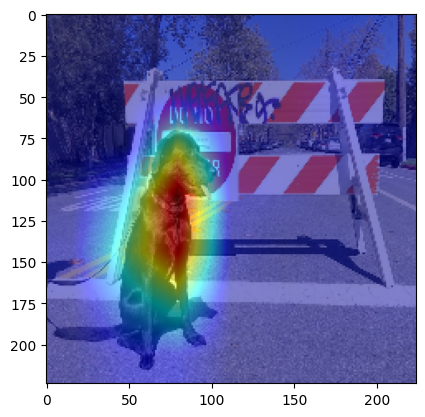

In [17]:
# Create explainer object
explainer = xai.Explainer(
    model=model,
    task=xai.Task.CLASSIFICATION,
)

# Return overlayed image
explanation = explainer(preprocessed_image, 
                        targets=[retriever_class_index],
                        overlay=True
                        )

retriever_raw_sal_map = explanation.saliency_map[retriever_class_index]
plt.imshow(retriever_raw_sal_map);

# Save saliency map
output = base_artifacts_dir / "overlay"
explanation.save(output)

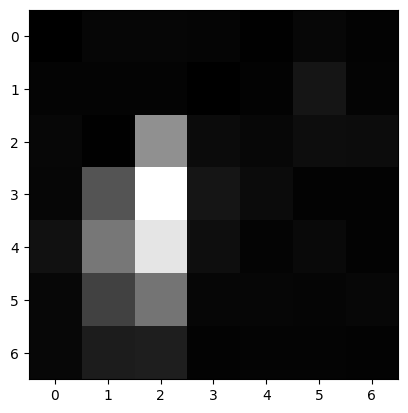

In [18]:
# Return low-resolution gray-scale saliency map
explanation = explainer(preprocessed_image, 
                        targets=[retriever_class_index],
                        resize=False,
                        colormap=False,
                        )

retriever_raw_sal_map = explanation.saliency_map[retriever_class_index]
plt.imshow(retriever_raw_sal_map, cmap='gray');

# Save saliency map
output = base_artifacts_dir / "grayscale"
explanation.save(output)

## White Box explainer
[back to top ⬆️](#Table-of-contents:)


### Recipro-CAM explain method
[back to top ⬆️](#Table-of-contents:)


The White-Box explainer treats model as a white box and needs to make inner modifications. It adds extra XAI nodes after backbone to estimate which activations are important for model prediction.

If method wasn't specifed, XAI branch will be generated with [ReciproCAM](https://arxiv.org/abs/2209.14074) method.

By default, the insertion of XAI branch will be done automatically by searching correct node.

It works fast and precise and requires only one model inference.

In [19]:
# Create explainer object
explainer = xai.Explainer(
    model=model,
    task=xai.Task.CLASSIFICATION,
    preprocess_fn=preprocess_fn,
    
    # defaults to ExplainMode.AUTO
    explain_mode=ExplainMode.WHITEBOX,
    # ReciproCAM is the default XAI method for CNNs
    explain_method=xai.Method.RECIPROCAM,
)

INFO:openvino_xai:Target insertion layer is not provided - trying to find it in auto mode.
INFO:openvino_xai:Using ReciproCAM method (for CNNs).
INFO:openvino_xai:Explaining the model in white-box mode.


### Insert XAI branch
[back to top ⬆️](#Table-of-contents:)

It's possible to update model with XAI branch to save it and use it in own pipeline.
This code will return IR model with an additional `saliency_map` output.
    

In [20]:
# insert XAI branch
model_xai: ov.Model
model_xai = xai.insert_xai(
    model,
    task=xai.Task.CLASSIFICATION,
    explain_method=xai.Method.RECIPROCAM,
    target_layer="MobilenetV3/Conv_1/Conv2D",  # MobileNet V3
    embed_scaling=True,
)

INFO:openvino_xai:Target insertion layer MobilenetV3/Conv_1/Conv2D is provided.
INFO:openvino_xai:Using ReciproCAM method (for CNNs).
INFO:openvino_xai:Insertion of the XAI branch into the model was successful.


### Insertion-related parameters
[back to top ⬆️](#Table-of-contents:)


If automatic search for correct node fails, you can set up a correct node manually with `target_layer` argument. 
For classification it's the last backbone node with shape [-1, num_channels, feature_map_height, feature_map_width]. For example, for MobileNetV3 it will be `/backbone/conv/conv.2/Div` layer with [-1, 960, 7, 7] input shape.

`embed_scaling` **default True** (for speed purposes), this parameter adds normalization to the XAI branch, which results in being able to visualize saliency maps right away without further postprocessing.

In [21]:
# Create explainer object
explainer = xai.Explainer(
    model=model,
    task=xai.Task.CLASSIFICATION,
    preprocess_fn=preprocess_fn,
    explain_mode=ExplainMode.WHITEBOX,
    explain_method=xai.Method.RECIPROCAM,
    
    # target_layer="last_conv_node_name",  # target_layer - node after which XAI branch will be inserted
    target_layer="MobilenetV3/Conv_1/Conv2D",
    embed_scaling=True,  # True by default.  If set to True, saliency map scale (0 ~ 255) operation is embedded in the model
)

INFO:openvino_xai:Target insertion layer MobilenetV3/Conv_1/Conv2D is provided.
INFO:openvino_xai:Using ReciproCAM method (for CNNs).
INFO:openvino_xai:Explaining the model in white-box mode.


## Black Box explainer
[back to top ⬆️](#Table-of-contents:)

The Black Box treats the model as a black box without altering its structure. So, this method will work on any model that can be inferred and return the class probabilities as output.

The [RISE](https://arxiv.org/pdf/1806.07421.pdf) algorithm used for BlackBox applies random masks to hide parts of the image, gets result class probabilities and by that calculates the "importance" of each part of the image for final results. After a few thousands of inferences the summarized saliency map is generated.

Although it's convenient to predict every model as a black-box, this explain algorithm might require many inferences (5000 by default) to generate high-quality saliency map.

In [22]:
# Create explainer object
explainer = xai.Explainer(
    model=model,
    task=xai.Task.CLASSIFICATION,
    preprocess_fn=preprocess_fn,
    postprocess_fn=postprocess_fn,
    explain_mode=ExplainMode.BLACKBOX,  # defaults to AUTO
)

# Generate explanation
explanation = explainer(
    image,
    # CUSTOM list of classes to explain, also ALL possible
    # targets=[retriever_class_index],
    targets=-1,
    overlay=True,
    num_masks=1000,  # kwargs of the RISE algo
)

INFO:openvino_xai:Explaining the model in black-box mode.
Explaining in synchronous mode:   0%|          | 0/1000 [00:00<?, ?it/s]


ValueError: operands could not be broadcast together with shapes (0,3) (1,224,224,3) 

In [23]:
def postprocess_fn(x: OVDict):
    # Implementing own post-process function based on model's implementation
    # Output logits
    return x[0]

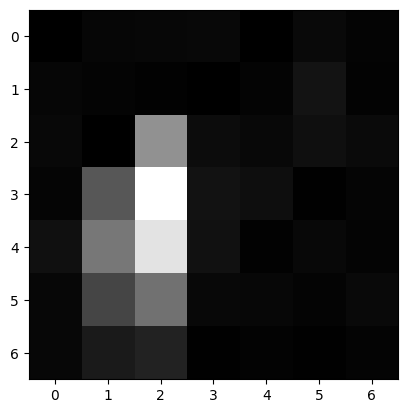

In [24]:
# Save saliency map
output = base_artifacts_dir / "blackbox_explain"
explanation.save(output)

# See saved saliency maps
image_sal_map = cv2.imread(f"{output}/target_{retriever_class_index}.jpg")
image_sal_map = cv2.cvtColor(image_sal_map, cv2.COLOR_BGR2RGB)
plt.imshow(image_sal_map);

For `BlackBox explainer` the number of masks and cells is crucial for good result. On the example above we see that number of masks wasn't enough for qualitive enough map.

 Varying `num_cells`/`num_masks` parameters can achieve different goals:
- To speed up the explanation, we can reduce the number of `num_mask`. But the result saliency maps will decrease the quality, so this option can be used for big and focused objects.
- The more `num_cells` we have, the more fine-grained result we can expect. But more `num_cells` requires bigger `num_masks` to converge. This would work better work for classes with complex shape.

## Advanced
[back to top ⬆️](#Table-of-contents:)

### Import ImageNet label names and add them to saliency maps
[back to top ⬆️](#Table-of-contents:)

If model doesn't have a label list in meta information, the saved saliency map will have the predicted class index, not name. For example,  `coco_target_206.jpg` instead of `coco_target_retriever.jpg`. 

To see the label names for saliency maps more conveniently, let's add ImageNet label list info into explaination parameters. 

In [25]:
imagenet_filename = download_file(
    "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/datasets/imagenet/imagenet_2012.txt",
    directory="data",
)

imagenet_classes = imagenet_filename.read_text().splitlines()

'data/imagenet_2012.txt' already exists.


In [26]:
imagenet_labels = []
for label in imagenet_classes:
    class_label = " ".join(label.split(" ")[1:])
    first_class_label = class_label.split(",")[0].replace(" ", "_")
    imagenet_labels.append(first_class_label)

print(" ".join(imagenet_labels[:10]))

tench goldfish great_white_shark tiger_shark hammerhead electric_ray stingray cock hen ostrich


In [27]:
# The model description states that for this model, class 0 is a background.
# Therefore, a background must be added at the beginning of imagenet_classes.
imagenet_labels = ["background"] + imagenet_labels

In [28]:
# Create explainer object
explainer = xai.Explainer(
    model=model,
    task=xai.Task.CLASSIFICATION,
    preprocess_fn=preprocess_fn,
    explain_mode=ExplainMode.WHITEBOX,
)

# Adding ImageNet label names.
explanation = explainer(image,
                        # Return saliency maps for 2 named labels
                        targets=["flat-coated_retriever", "microwave"],  # Also label indexes [206, 652] are possible as target
                        label_names=imagenet_labels
                        )

INFO:openvino_xai:Target insertion layer is not provided - trying to find it in auto mode.
INFO:openvino_xai:Using ReciproCAM method (for CNNs).
INFO:openvino_xai:Explaining the model in white-box mode.


In [29]:
# Save saliency map
output = base_artifacts_dir / "label_names"
explanation.save(output)

Below in `output / "label_names"` you can see saved saliency maps with label name on it:

In [30]:
# See saliency mas saved in `output` with predicted label in image name
! ls -l $output

total 96
-rw-r--r-- 1 gzalessk gzalessk 33815 Jul  2 13:54 target_flat-coated_retriever.jpg
-rw-r--r-- 1 gzalessk gzalessk 61313 Jul  2 13:54 target_microwave.jpg


### Activation map explain method
[back to top ⬆️](#Table-of-contents:)


Activation map method shows the general attention map with no respect to classes. It can be useful to see which areas the model marks as important.

In case of explanation `explain_method==Method.ACTIVATIONMAP`, instead of saliency map for each class the activation map is returned as `explanation.saliency_map["per_image_map"]`.

INFO:openvino_xai:Target insertion layer is not provided - trying to find it in auto mode.
INFO:openvino_xai:Using ActivationMap method (for CNNs).
INFO:openvino_xai:Explaining the model in white-box mode.


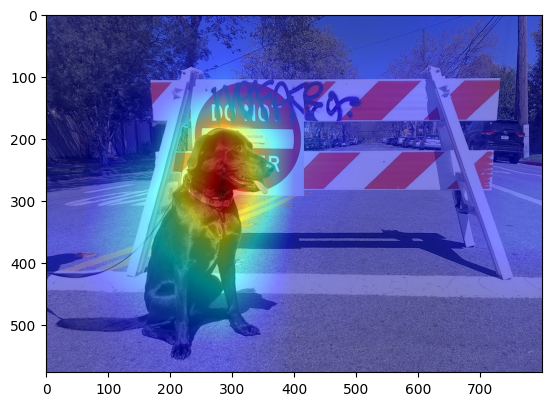

In [31]:
# Create explainer object
explainer = xai.Explainer(
    model=model,
    task=xai.Task.CLASSIFICATION,
    preprocess_fn=preprocess_fn,
    explain_mode=ExplainMode.WHITEBOX,
    
    explain_method=xai.Method.ACTIVATIONMAP,
)

explanation = explainer(image, targets=-1, overlay=True)
activation_map = explanation.saliency_map["per_image_map"]

plt.imshow(activation_map)
plt.show()